<a href="https://colab.research.google.com/github/kridtapon/STD-MOM-Breakout-Engine/blob/main/STD_MOM_Breakout_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.63
    Uninstalling yfinance-0.2.63:
      Successfully uninstalled yfinance-0.2.63


In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Define the stock symbol and time period
symbol = 'STX'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Standard Deviation Channel ===
sma_period = 20
sma = df['Close'].rolling(sma_period).mean()
std = df['Close'].rolling(sma_period).std()
upper_band = sma + 2 * std
lower_band = sma - 2 * std

df['SMA'] = sma
df['Upper'] = upper_band
df['Lower'] = lower_band

# === Momentum ===
momentum_period = 10
df['Momentum'] = df['Close'] - df['Close'].shift(momentum_period)
df['Momentum_Delta'] = df['Momentum'] - df['Momentum'].shift(1)

# === Volume Filter ===
df['Volume_Avg'] = df['Volume'].rolling(20).mean()
df['Volume_Spike'] = df['Volume'] > df['Volume_Avg']

# === Entry & Exit Rules ===

# Long Entry: breakout above upper band and positive/increasing momentum
df['Entry'] = (
    (df['Close'] > df['Upper']) &
    (df['Momentum'] > 0) &
    (df['Momentum_Delta'] > 0) &
    df['Volume_Spike']   # Optional volume filter
)

# Short Entry: breakdown below lower band and negative/decreasing momentum
df['Exit'] = (
    (df['Close'] < df['Lower']) &
    (df['Momentum'] < 0) &
    (df['Momentum_Delta'] < 0) &
    df['Volume_Spike']   # Optional volume filter
)

# Filter data for test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals by 1 to simulate next-bar entry
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Portfolio Simulation ===
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],  # Use next-day open for simulation
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Output Results ===
print(portfolio.stats())
portfolio.plot().show()


/tmp/ipython-input-7-1564142054.py:12: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           197389.380401
Total Return [%]                         97.38938
Benchmark Return [%]                    76.230599
Max Gross Exposure [%]                      100.0
Total Fees Paid                       2307.181007
Max Drawdown [%]                        26.043592
Max Drawdown Duration           315 days 00:00:00
Total Trades                                   10
Total Closed Trades                            10
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 50.0
Best Trade [%]                          62.237385
Worst Trade [%]                        -14.397084
Avg Winning Trade [%]                   26.145564
Avg Losing Trade [%]                    -7.800209


In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
import plotly.graph_objects as go

# === Download Data ===
symbol = 'STX'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Optimization Ranges ===
sma_range = range(5, 30, 2)
momentum_range = range(5, 30, 2)
volume_range = range(5, 30, 2)

results = []

# === Grid Search Optimization ===
for sma_period, momentum_period, volume_rolling in product(sma_range, momentum_range, volume_range):
    df = df.copy()

    # === Indicators ===
    sma = df['Close'].rolling(sma_period).mean()
    std = df['Close'].rolling(sma_period).std()
    upper_band = sma + 2 * std
    lower_band = sma - 2 * std
    df['Upper'] = upper_band
    df['Lower'] = lower_band

    df['Momentum'] = df['Close'] - df['Close'].shift(momentum_period)
    df['Momentum_Delta'] = df['Momentum'] - df['Momentum'].shift(1)

    df['Volume_Avg'] = df['Volume'].rolling(volume_rolling).mean()
    df['Volume_Spike'] = df['Volume'] > df['Volume_Avg']

    # === Signals ===
    df['Entry'] = (
        (df['Close'] > df['Upper']) &
        (df['Momentum'] > 0) &
        (df['Momentum_Delta'] > 0) &
        df['Volume_Spike']
    )
    df['Exit'] = (
        (df['Close'] < df['Lower']) &
        (df['Momentum'] < 0) &
        (df['Momentum_Delta'] < 0) &
        df['Volume_Spike']
    )

    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    shifted_entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    shifted_exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    # === Portfolio Simulation ===
    if len(df_test) > 0:
        pf = vbt.Portfolio.from_signals(
            close=df_test['Open'],
            entries=shifted_entries,
            exits=shifted_exits,
            init_cash=100_000,
            fees=0.001,
            slippage=0.002,
            freq='D'
        )
        total_return = pf.total_return()
    else:
        total_return = np.nan

    results.append({
        'sma': sma_period,
        'momentum': momentum_period,
        'volume': volume_rolling,
        'return': total_return
    })

# === Convert Results to DataFrame ===
results_df = pd.DataFrame(results)

# === 3D Scatter Plot ===
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=results_df['sma'],
    y=results_df['momentum'],
    z=results_df['volume'],
    mode='markers',
    marker=dict(
        size=6,
        color=results_df['return'],  # color by return
        colorscale='Viridis',        # choose your colorscale
        colorbar=dict(title='Return'),  # show colorbar
        opacity=0.8
    ),
    text=[f"Return: {r:.2%}" for r in results_df['return']]  # optional hover text
))

fig.update_layout(
    title="3D Parameter Optimization: Color = Return",
    scene=dict(
        xaxis_title='SMA Period',
        yaxis_title='Momentum Period',
        zaxis_title='Volume Rolling'
    ),
    width=900,
    height=700
)

fig.show()

# === Find and Print Best Parameters ===
best_params = results_df.loc[results_df['return'].idxmax()]
print("Best Parameters:")
print(f"SMA Period: {best_params['sma']}")
print(f"Momentum Period: {best_params['momentum']}")
print(f"Volume Rolling: {best_params['volume']}")
print(f"Return: {best_params['return']:.2%}")

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
/tmp/ipython-input-13-59372718.py:55: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-13-59372718.py:56: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-13-59372718.py:55: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-13-59372718.

Best Parameters:
SMA Period: 9.0
Momentum Period: 17.0
Volume Rolling: 5.0
Return: 178.28%


In [14]:
# === Standard Deviation Channel ===
sma_period = 9
sma = df['Close'].rolling(sma_period).mean()
std = df['Close'].rolling(sma_period).std()
upper_band = sma + 2 * std
lower_band = sma - 2 * std

df['SMA'] = sma
df['Upper'] = upper_band
df['Lower'] = lower_band

# === Momentum ===
momentum_period = 17
df['Momentum'] = df['Close'] - df['Close'].shift(momentum_period)
df['Momentum_Delta'] = df['Momentum'] - df['Momentum'].shift(1)

# === Volume Filter ===
df['Volume_Avg'] = df['Volume'].rolling(5).mean()
df['Volume_Spike'] = df['Volume'] > df['Volume_Avg']

# === Entry & Exit Rules ===

# Long Entry: breakout above upper band and positive/increasing momentum
df['Entry'] = (
    (df['Close'] > df['Upper']) &
    (df['Momentum'] > 0) &
    (df['Momentum_Delta'] > 0) &
    df['Volume_Spike']   # Optional volume filter
)

# Short Entry: breakdown below lower band and negative/decreasing momentum
df['Exit'] = (
    (df['Close'] < df['Lower']) &
    (df['Momentum'] < 0) &
    (df['Momentum_Delta'] < 0) &
    df['Volume_Spike']   # Optional volume filter
)

# Filter data for test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals by 1 to simulate next-bar entry
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Portfolio Simulation ===
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],  # Use next-day open for simulation
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Output Results ===
print(portfolio.stats())
portfolio.plot().show()

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           278280.998284
Total Return [%]                       178.280998
Benchmark Return [%]                    76.230599
Max Gross Exposure [%]                      100.0
Total Fees Paid                       2223.944718
Max Drawdown [%]                        28.439644
Max Drawdown Duration           262 days 00:00:00
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 62.5
Best Trade [%]                          79.232392
Worst Trade [%]                        -25.848188
Avg Winning Trade [%]                   37.969156
Avg Losing Trade [%]                    -14.09294


/tmp/ipython-input-18-1876821923.py:11: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


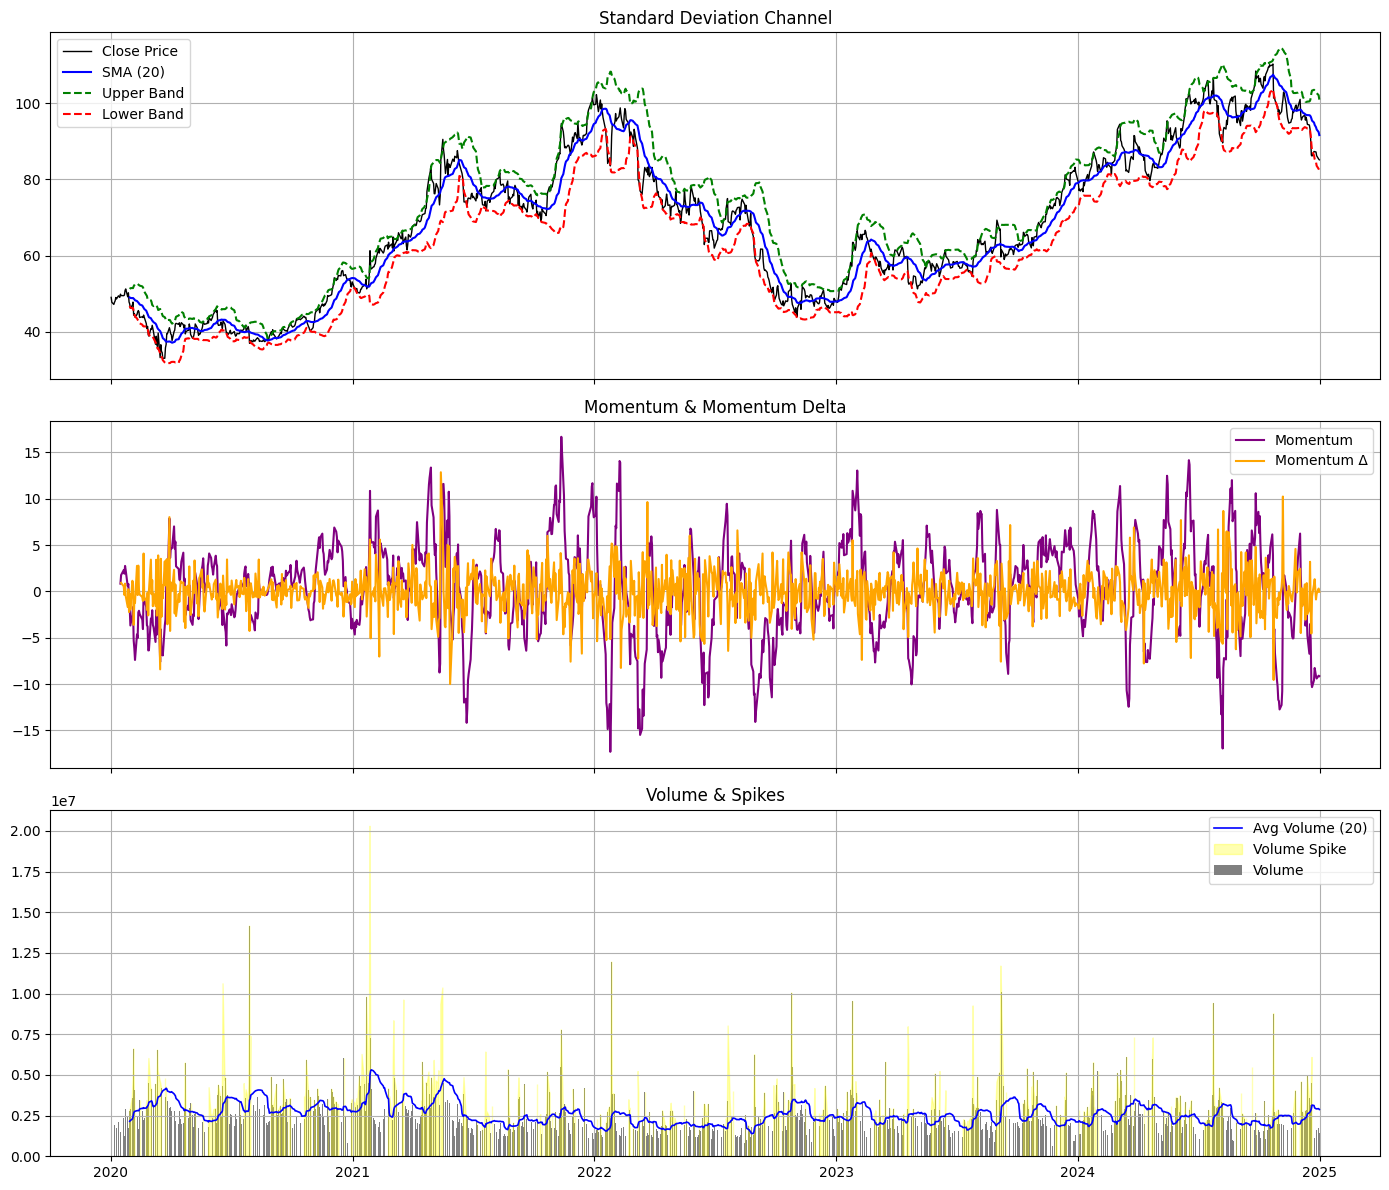

In [18]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the stock symbol and time period
symbol = 'STX'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Standard Deviation Channel ===
sma_period = 20
sma = df['Close'].rolling(sma_period).mean()
std = df['Close'].rolling(sma_period).std()
upper_band = sma + 2 * std
lower_band = sma - 2 * std

df['SMA'] = sma
df['Upper'] = upper_band
df['Lower'] = lower_band

# === Momentum ===
momentum_period = 10
df['Momentum'] = df['Close'] - df['Close'].shift(momentum_period)
df['Momentum_Delta'] = df['Momentum'] - df['Momentum'].shift(1)

# === Volume Filter ===
df['Volume_Avg'] = df['Volume'].rolling(20).mean()
df['Volume_Spike'] = df['Volume'] > df['Volume_Avg']

# === Plotting ===
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Panel 1: Standard Deviation Channel
ax1.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)
ax1.plot(df.index, df['SMA'], label='SMA (20)', color='blue', linewidth=1.5)
ax1.plot(df.index, df['Upper'], label='Upper Band', color='green', linestyle='--')
ax1.plot(df.index, df['Lower'], label='Lower Band', color='red', linestyle='--')
ax1.set_title('Standard Deviation Channel')
ax1.legend()
ax1.grid(True)

# Panel 2: Momentum
ax2.plot(df.index, df['Momentum'], label='Momentum', color='purple')
ax2.plot(df.index, df['Momentum_Delta'], label='Momentum Δ', color='orange')
ax2.set_title('Momentum & Momentum Delta')
ax2.legend()
ax2.grid(True)

# Panel 3: Volume with Spike Highlight
ax3.bar(df.index, df['Volume'], label='Volume', color='gray')
ax3.plot(df.index, df['Volume_Avg'], label='Avg Volume (20)', color='blue', linewidth=1.2)
ax3.fill_between(df.index, 0, df['Volume'], where=df['Volume_Spike'], color='yellow', alpha=0.3, label='Volume Spike')
ax3.set_title('Volume & Spikes')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()
